In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Define the initial distribution
def init_dist(x,width,amp):
    A0 = np.zeros(np.shape(x))
    A0temp = np.exp(-width**2/(width**2 - x**2))
    inrange = (x > -width)*(x < width)
    A0[inrange] = A0temp[inrange]
#     integral = np.trapz(A0,x)
#     amp = total/integral
    return amp*np.exp(1)*A0

## Part 1: Volcanic aerosols
The volcanic eruption is modelled by an emission of aerosols with initial relative concentration distribution modelled by
$$A_0(x) = B'\begin{cases}
            e^{-\frac{a^2}{a^2-x^2}}, \|x\|<a \\
            0, \|x\|>a
            \end{cases}$$
            
The aerosols spread in space and time by diffusion, and are also precipated out. The temperal spatial behaviour of the aerosol concentrations are modelled by Fick's law of diffusion:
$$A_t = DA_{xx} - \gamma A$$
where D is a diffusion rate and $\gamma$ is a precipitation rate. The range is the latitude range, $x=[-90^\circ,90^\circ]$ We use Neumann boundary conditions $\frac{dA}{dx}=0$ at $x=-90^\circ$ and $x=90^\circ$.

Numerically, this is solved as follows:
$$ \frac{dA_i}{dt} = D\frac{A_{i-1} - 2A_i + A_{i+1}}{h^2} - \gamma A_i$$
for i = 2,3,...,N-2
$$ \frac{dA_1}{dt} = D\frac{-A_1 + A_2}{h^2} - \gamma A_1$$
$$ \frac{dA_{N-1}}{dt} = D\frac{A_{N-2} - A_{N-1}}{h^2} - \gamma A_{N-1}$$
$$A_0 = A_1, A_{N-1} = A_n$$
$$A_i(t+\Delta t) \approx A_i(t) + \frac{dA_i}{dt}\Delta t$$

Because we are using the Euler method to compute the system evolution in time, we must be conscious of the stability of the solver.

$$A_i(t+\Delta t) \approx A_i(t) + \left[D\frac{A_{i-1} - 2A_i + A_{i+1}}{h^2} - \gamma A_i\right]\Delta t
                   = \left(1 - \Delta t\left(2\frac{D}{h^2} + \gamma\right)\right) A_i(t) + \frac{D}{h^2}(A_{i-1} + A_{i+1})$$

So stability is ensured if $\Delta t\left(2\frac{D}{h^2} + \gamma\right) < 1$.

Assumptions:
- We are looking at a 1D model of the system, meaning that we ignore the change in area as latitudes become further from 0. We assume that aerosol conservation applies only in 1D.
- Aerosol concentrations are relative. The factor $A$ in the initial distribution determines the total relative amount of emitted aerosols. $B'e^{-1}$ cannot exceed 1, or $B' \leq e$. If $B = B'e^{-1}$, then $B\leq 1$

In [9]:
# Constants
D = 30        # Diffusion rate [(lattitude degrees)^2/month]
gamma = 0.05  # Precipitation rate [1/month]

a = 15          # Width of eruption/aerosol output in lattitude degrees
B = 0.5         # Maximum relative aerosol concentration

t_end = 12*10 # stop time in MONTHS
dt = 0.2     # step time [months]

N = 50        # number of intervals
x0 = -90      # South pole lattitude
xL = 90       # North pole lattitude

# set up position and time intervals and step sizes
x = np.linspace(x0,xL,N+1)
h =x[1] - x[0]   # step size [lattitude degrees]
print("h = ", h)

t = np.arange(0,t_end, dt)

# Check that the step sizes will lead to stable Euler method solutions:
print("Stable step sizes?", dt*(2*D/h**2 + gamma) < 1)
print("dt*(2*D/h^2 + gamma) = ", dt*(2*D/h**2 + gamma))

shape = (np.size(x), np.size(t))
print(shape)

h =  3.5999999999999943
Stable step sizes? True
dt*(2*D/h^2 + gamma) =  0.9359259259259289
(51, 600)


Text(0, 0.5, 'Aerosol concentration at equator')

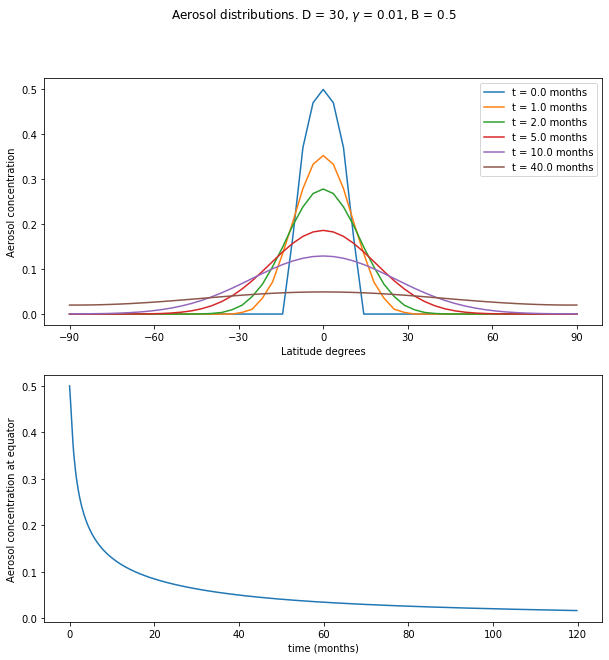

In [5]:
# Set up central difference matrix
CDM = np.zeros((N-1,N-1))
for i in range(N-1):
    CDM[i,i] += -gamma
    if i != 0:
        CDM[i,i] += -D/h**2
        CDM[i,i-1] = D/h**2
    if i != N-2:
        CDM[i,i] += -D/h**2
        CDM[i,i+1] = D/h**2
# print(CDM[0:3,0:3])
# print(CDM)

# Initialize the aerosol concentration array
A = np.zeros(shape)

# Solve the PDE
A[:,0] = init_dist(x,a,B) # Setting the initial condition
for j in range(1,np.size(t)):
    dAdt = np.zeros(np.shape(x))
    dAdt[1:N] = np.dot(CDM,A[1:N,j-1])
    dAdt[0] = dAdt[1]
    dAdt[N] = dAdt[N-1]
    A[:,j] = A[:,j-1] + dAdt*dt # Step through time
    
    
fig,ax = plt.subplots(2,figsize=(10,10))
# Plot the solutions: plot spatial distribution
legend = []
for i in [0,5,10,25,50,200]:
    ax[0].plot(x,A[:,i])
    legend.append('t = {} months'.format(t[i]))
ax[0].legend(legend)
fig.suptitle("Aerosol distributions. D = {}, $\gamma$ = {}, B = {}".format(D,gamma,B))
ax[0].set_xlabel('Latitude degrees')
ax[0].set_ylabel('Aerosol concentration')
ax[0].set_xticks([-90,-60,-30,0,30,60,90])

# Plot temporal distribution
ax[1].plot(t,A[25,:])
ax[1].set_xlabel('time (months)')
ax[1].set_ylabel('Aerosol concentration at equator')

In [6]:
# Code for animation

# from matplotlib.animation import FuncAnimation

# fig, ax = plt.subplots()
# line, = ax.plot([])     # A tuple unpacking to unpack the only plot
# ax.set_xlim(-90,90)
# ax.set_ylim(-1,35)

# def animate(frame_num):
#     line.set_data((x*180/np.pi, A[:,frame_num]))
#     return line

# anim = FuncAnimation(fig, animate, frames=np.size(t), interval=20)
# plt.show()

## Part 2: Radiation blocking

The emitted aerosols in the atmosphere have an effect on the amount of incoming solar radiation. Assume a simple linear relationship between aerosol concentration and radiation reduction:

$$\Phi(x,t) = 1 - \beta A(x,t)$$

where $\beta$ is a scale factor.

Other assumptions:
- Radiation reduction is only dependent on aerosol concentration, not on latitude (where the angle relative to the sun changes)

Text(0, 0.5, 'Relative incoming radiation at the equator')

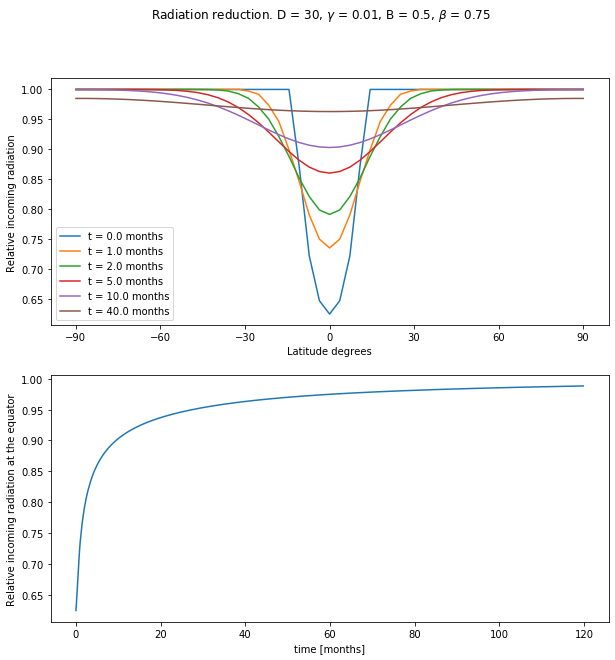

In [12]:
beta = 0.75

phi = 1 - beta*A

fig,ax = plt.subplots(2,figsize=(10,10))
# plot spatial distribution
legend = []
for i in [0,5,10,25,50,200]:
    ax[0].plot(x,phi[:,i])
    legend.append('t = {} months'.format(t[i]))
ax[0].legend(legend)
fig.suptitle(r"Radiation reduction. D = {}, $\gamma$ = {}, B = {}, $\beta$ = {}".format(D,gamma,B,beta))
ax[0].set_xlabel('Latitude degrees')
ax[0].set_ylabel('Relative incoming radiation')
ax[0].set_xticks([-90,-60,-30,0,30,60,90])

# plot temporal distribution
ax[1].plot(t,phi[25,:])
ax[1].set_xlabel('time [months]')
ax[1].set_ylabel('Relative incoming radiation at the equator')

## Part 3: Zonal averaging and time interpolating

We average the relative reduction in radiation for each of the 6 zones.

We also interpolate the time response of the radiation effect to get second accuracy (instead of month). Since the diffusion and precipitation rates are have characteristic time scales in the month/year regime, we can interpolate linearly between the current time steps (of roughly 1 week) to reduce it to second resolution without harm. The default interpolator in scipy.interpolate.interp1d is linear.

Text(0, 0.5, 'Relative incoming radiation')

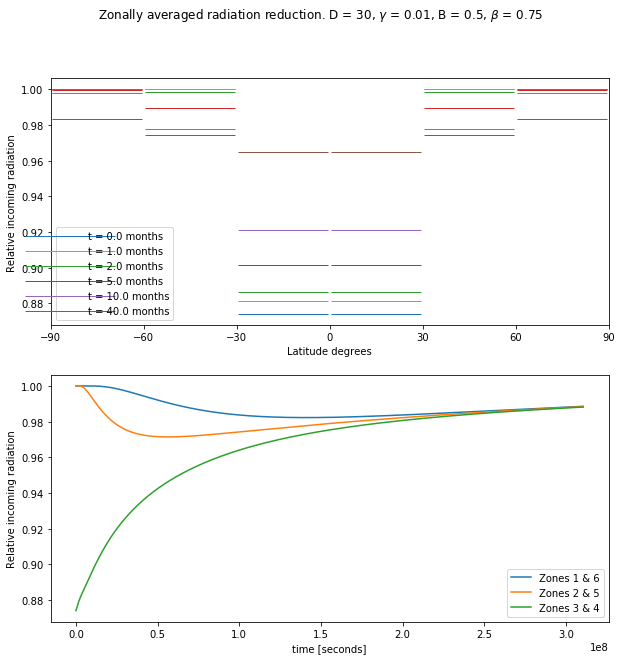

In [8]:
# Zonal averaging
phi_k = np.zeros((6,np.size(t)))
for i in range(np.size(t)):
    for j in range(-3,3):
        xrange = (x>=j*30)*(x<=(j+1)*30)
        phi_k[j+3,i] = np.mean(phi[xrange,i])

lattitudes = [-90,-60,-30,0,30,60,90]

fig,ax = plt.subplots(2,figsize=(10,10))
# plot spatial distribution
legend = []
for i in [0,5,10,25,50,200]:
    ax[0].plot(np.array(lattitudes[0:6])+15,phi_k[:,i],'_',markersize=90)
    legend.append('t = {} months'.format(t[i]))
ax[0].legend(legend)
fig.suptitle(r"Zonally averaged radiation reduction. D = {}, $\gamma$ = {}, B = {}, $\beta$ = {}".format(D,gamma,B,beta))
ax[0].set_xlabel('Latitude degrees')
ax[0].set_ylabel('Relative incoming radiation')
ax[0].set_xticks(lattitudes)

# plot temporal distribution
t_seconds = t*30*24*3600
for xx in range(3):
    ax[1].plot(t_seconds,phi_k[xx,:])
ax[1].legend(['Zones 1 & 6', 'Zones 2 & 5', 'Zones 3 & 4'])
ax[1].set_xlabel('time [seconds]')
ax[1].set_ylabel('Relative incoming radiation')

Zooming in to the time response shows that at this scale, we see that a linear interpolation makes sense.


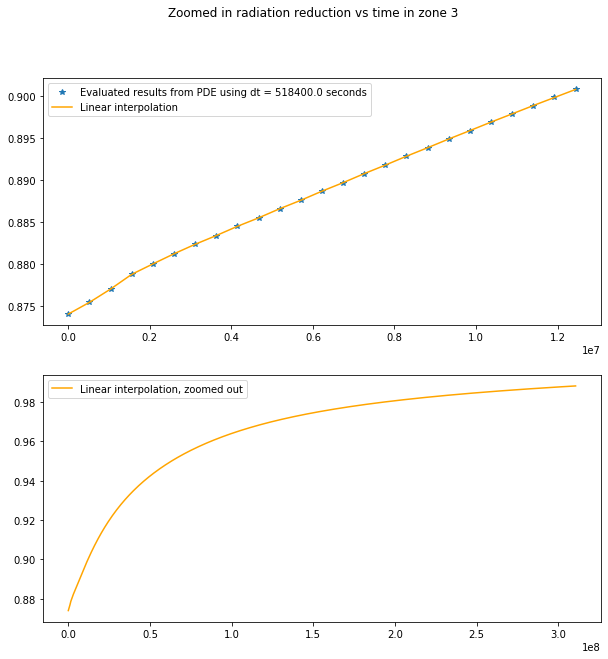

In [17]:
# Time interpolation.
fig,ax = plt.subplots(2,figsize=(10,10))
ax[0].plot(t[0:25]*30*24*3600,phi_k[2,0:25],'*')
fig.suptitle('Zoomed in radiation reduction vs time in zone 3')
print('Zooming in to the time response shows that at this scale, we see that a linear interpolation makes sense.')

phi_funcs = []
for i in range(6):
    phi_funcs.append(interp1d(t_seconds,phi_k[i,:]))

t_seconds_zoomed = np.linspace(0,t[24]*30*24*3600,100)
ax[0].plot(t_seconds_zoomed,phi_funcs[2](t_seconds_zoomed),color='orange')
ax[0].legend(['Evaluated results from PDE using dt = {} seconds'.format(dt*30*24*3600),'Linear interpolation'])

ax[1].plot(t_seconds,phi_funcs[2](t_seconds),color='orange')
ax[1].legend(['Linear interpolation, zoomed out'])

After a long time, $A_{xx}\approx 0$, so the PDE reduces to $A_t = -\gamma A$, which has solution $A(x,t) \propto e^{-\gamma t}$, so relative radiation decrease has long-time form
$$\phi_{long}(t) = 1-ae^{-\gamma t}$$

In [48]:
# Extrapolate A to longer times:
mon2sec = 30*24*3600

t_end_long = 1E11/mon2sec
dt_long = 120 # [months]
t_span_long = np.arange(t_end,t_end_long,dt_long)
# amp = (1-phi_k[2,-1])*np.exp(gamma*t[-1])
# phi_long = 1-amp*np.exp(-gamma*t_span_long)
#phi_extension = np.array([phi_long,phi_long,phi_long,phi_long,phi_long,phi_long,])
phi_extension = np.array(list(map(lambda k: 
                                  1-(1-phi_k[k,-1])*np.exp(gamma*t[-1])
                                    *np.exp(-gamma*t_span_long)
                                  ,range(6))))
phi_k_extended = np.append(phi_k,phi_extension,axis=1)
t_span = np.append(t,t_span_long)

phi_funcs_ext = []
for i in range(6):
    phi_funcs_ext.append(interp1d(t_span,phi_k_extended[i,:]))

In [41]:
a = np.zeros((2,3))
b = np.ones((2,2))

print(np.append(a,b,axis=1))

a = np.arange(6)
print(np.array([a,a,a]))

[[0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1.]]
[[0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]]
